## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date']=pd.to_datetime(data['date'])

In [5]:
data.groupby('group')['date'].agg(['min', 'max'])


,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [6]:
data.groupby('group')['user_id'].agg(['count']) # кол-во посещений страницы

,count
group,
A,147202
B,147276


In [7]:
data.groupby('group')['purchase'].agg(['sum']) # кол-во покупок

,sum
group,
A,17723
B,17514


In [8]:
data.groupby('group')['price'].agg(['sum'])/1000000 # сумма покупок

,sum
group,
A,1436.26
B,1554.10


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [9]:
a_data = data[data['group'] == 'A']
b_data = data[data['group'] == 'B']
user_intersection = set(a_data['user_id']).intersection(set(b_data['user_id']))
print(len(user_intersection))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [10]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

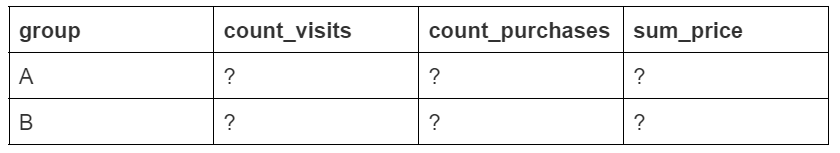
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [11]:
summary_table=updated_data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})

In [12]:
summary_table=summary_table.rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

**Вывод:** Относительно общей выборки, кол-во посетителей сайта в группах А и В разделилось примерно поровну, следовательно делаем вывод, что наша выборка сбалансирована.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [13]:
summary_table['conversion']=round(summary_table['count_purchases']/summary_table['count_visits']*100, 2)
summary_table['mean_check']=round(summary_table['sum_price']/summary_table['count_purchases'])
summary_table

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

**Вывод:** Если смотреть по метрике конверсии в группах, то конверсия в группе А больше, чем в В. Это означает, что в группе А путевок купили больше, чем в группе В. Однако, если смотреть по метрике среднего чека, то в группе В средний чек больше, чем в группе А. Это означает, что посетители из группы В покупали более дорогие туры, чем посетители из группы А. 

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [14]:
purchase_ability=updated_data.pivot_table(
    values='purchase',
    columns='group',
    index='price',
    aggfunc='count'
)
purchase_ability=purchase_ability.drop(labels = [0], axis = 0)
purchase_ability

group,A,B
price,,
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

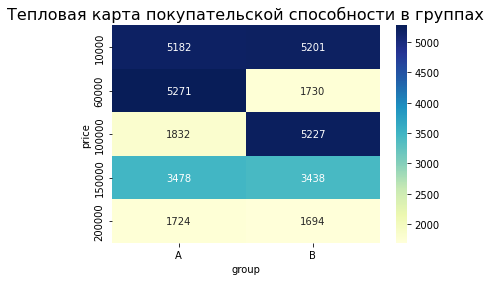

In [15]:
heatmap=sns.heatmap(data=purchase_ability, cmap='YlGnBu', annot=True, fmt='.5g')
heatmap.set_title('Тепловая карта покупательской способности в группах', fontsize=16);

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Для наглядности тепловой карты мы убрали посетителей сайта, которые ничего не купили. 

**Вывод:** Если посмотреть визуально на карту, то можно сделалать вывод, что покупательская способность в двух группах примерно на одном уровне. 
Однако видим противоположную ситуацию по турам за 60тыс.руб. и 100тыс.руб. Путешвки за 60 тыс.руб. больше приобретают пользователи из группы А, чем в В. А вот путевки за 100 тыс.руб. больше покупают пользователи из группы В. Из чего делается вывод, что общая сумма выкупленных путевок группы В больше, чем группы А. 

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [46]:
daily_data = updated_data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})
daily_data['conversion']=round(daily_data['count_purchases']/daily_data['count_visits']*100, 2)
daily_data['mean_check']=round(daily_data['sum_price']/daily_data['count_purchases'])
daily_data

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0
5,2021-01-04,B,6536,764,68030000,11.69,89045.0
6,2021-01-05,A,6433,790,64550000,12.28,81709.0
7,2021-01-05,B,6511,749,63550000,11.50,84846.0
8,2021-01-06,A,6606,764,63410000,11.57,82997.0
9,2021-01-06,B,6751,838,75020000,12.41,89523.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [47]:
# создание кумулятивных признаков
daily_data['cum_visits']=daily_data.groupby(['group'])['count_visits'].cumsum()
daily_data['cum_purchase']=daily_data.groupby(['group'])['count_purchases'].cumsum()
daily_data['cum_price']=daily_data.groupby(['group'])['sum_price'].cumsum()
daily_data['cum_conversion']=round(daily_data['cum_purchase']/daily_data['cum_visits']*100, 2)
daily_data['cum_check']=round(daily_data['cum_price']/daily_data['cum_purchase'])
daily_data

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_visits,cum_purchase,cum_price,cum_conversion,cum_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0,9450,1107,91410000,11.71,82575.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0,9480,1099,95620000,11.59,87006.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0,16016,1906,155660000,11.90,81668.0
5,2021-01-04,B,6536,764,68030000,11.69,89045.0,16016,1863,163650000,11.63,87842.0
6,2021-01-05,A,6433,790,64550000,12.28,81709.0,22449,2696,220210000,12.01,81680.0
7,2021-01-05,B,6511,749,63550000,11.50,84846.0,22527,2612,227200000,11.59,86983.0
8,2021-01-06,A,6606,764,63410000,11.57,82997.0,29055,3460,283620000,11.91,81971.0
9,2021-01-06,B,6751,838,75020000,12.41,89523.0,29278,3450,302220000,11.78,87600.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

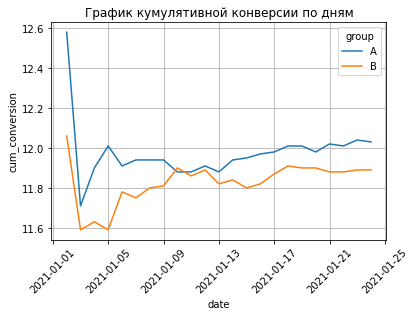

In [18]:
plot_cum_conversion=sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group');
plot_cum_conversion.set_title('График кумулятивной конверсии по дням')
plot_cum_conversion.xaxis.set_tick_params(rotation = 45)
plot_cum_conversion.grid(True);


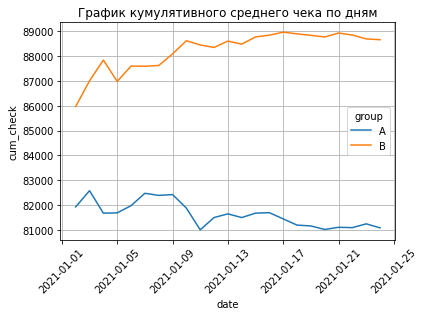

In [19]:
plot_cum_check=sns.lineplot(x='date', y='cum_check', data=daily_data, hue='group');
plot_cum_check.set_title('График кумулятивного среднего чека по дням')
plot_cum_check.xaxis.set_tick_params(rotation = 45)
plot_cum_check.grid(True);

**Вывод:** Оба показателя стабилизировались после 13 января, что говорит о том, что A/B-тестирование - завершено. Конверсия в группе A стабильно выше, чем в группе B, а вот средний чек, наоборот, выше в группе B, чем в A.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [21]:
alpha=0.05
_, p_value=proportions_ztest(
    count=summary_table['count_purchases'],
    nobs=summary_table['count_visits'],
    alternative='larger'
)
print('p-value: ', round(p_value, 2))
if p_value < alpha:
    print ('Отвергаем нулевую гипотезу. Конверсия в группе А больше чем конверсия в группе B')
else:
    print ('Принимаем нулевую гипотезу. Конверсии в группах А и B равны')

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

**Вывод:** Конверсии в группах A и B при уровне значимости 0.05 равны. 

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [22]:
a_data = updated_data[updated_data['group'] == 'A']
b_data = updated_data[updated_data['group'] == 'B']

In [23]:
# функция определение доверительного интервала
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [30]:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
display (conf_interval_a)
display (conf_interval_b)

(11.87, 12.2)

(11.73, 12.06)

In [25]:
# функция определение доверительного интервала разницы конверсий
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [26]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
diff_inverval

(-0.38, 0.09)

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

**Вывод:** Так как доверительный интервал разницы конверсий охватывает точку 0, то это означает что варианты A и B равнозначны по метрике конверсий

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

При проверке гипотезы о нормальности распределения признака будем использовать тест Шапиро-Уилка. 

Гипотезы звучат следующим образом:
* $H_0$: Распределение нормальное; 
* $H_1$: Распределение отлино от нормального;


In [48]:
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']

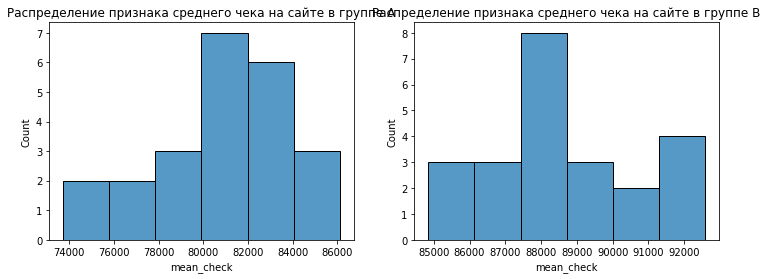

In [51]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для среднего времени на сайте в каждой группе
sns.histplot(x='mean_check', data=daily_data_a, ax=axes[0])
sns.histplot(x='mean_check', data=daily_data_b, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение признака среднего чека на сайте в группе А');
axes[1].set_title('Распределение признака среднего чека на сайте в группе B');

Если распределение в группе A похоже на нормальное распределение (с правосторонней асимметрией), то распределение в группе B визуально отлично от нормального. Проверим это на стат.тесте Шапиро-Уилка

In [53]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data_a['mean_check'])
shapiro_result_b = shapiro(daily_data_b['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Принимаем нулевую гипотезу.')

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу.


**Вывод:** Статистический тест Шапиро-Уилка показал нам, что в обоих случаях p_value больше, чем уровень значимости альфа в 5%. Следовательно, мы принимаем нулевую гипотезу о том, что распределения в обоих группах нормальное. 

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [54]:
alpha=0.05
results=ttest_ind(
    a=daily_data_a['mean_check'],
    b=daily_data_b['mean_check'],
    alternative='less'
)

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Принимаем нулевую гипотезу')

Отвергаем нулевую гипотезу


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

**Вывод:** T-тест показал, что при уровне значимости в 5% мы отвергаем нулевую гипотезу и принимаем альтернативную, которая говорит, что средний чек в группе А меньше, чем в группе B. 

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [55]:
# функция определение доверительного интервала при неизвестном стандартном отклонении
def conf_intevals (n, x_mean, x_std, gamma=0.95):
    k=n-1
    alpha=1-gamma
    t_crit = -t.ppf(alpha/2, k)
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    return (round(lower_bound), round(upper_bound))

In [63]:
conf_interval_a = conf_intevals( n=daily_data_a['mean_check'].count(), 
                                x_mean=daily_data_a['mean_check'].mean(),
                                x_std=daily_data_a['mean_check'].std())
conf_interval_a

(79630, 82308)

In [64]:
conf_interval_b = conf_intevals( n=daily_data_b['mean_check'].count(), 
                                x_mean=daily_data_b['mean_check'].mean(),
                                x_std=daily_data_b['mean_check'].std())
conf_interval_b

(87626, 89526)

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

**Вывод:** Доверительные интервалы для групп A и B не переекаются, это означает, что истинное значение среднего чека в группе B будет выше, чем истинное значение среднего чека в группе A.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

**Вывод:** Проведя стат.тесты двух метрик - конверсии посадочных страниц и размер среднего чека между двумя группами A и B, мы пришли к выводу, что хоть и конверсия между группами не отличается, но средний чек в группе B выше. Поэтому вариант с посадочной страницей в группе B наиболее выгодным, чем существующая посадочная страница. 